# hmmlearn

    model=hmm.MultinomialHMM(n_components=3, transmat_prior=transmat, startprob_prior=startprob, params="tse")
    model.n_features=4
    model.emissionprob_=np.array([[0, 1/2, 1/2, 0], [2/3, 0, 1/3, 0], [0, 0, 1/3, 2/3]])
    model.sample()
    
> NotFittedError: This MultinomialHMM instance is not fitted yet. Call 'fit' with appropriate arguments before using this method. 

Same with any combination of `init_params` or `params`

# [pomegranate](https://pomegranate.readthedocs.io/en/latest/index.html)

# Functions and imports

In [32]:
%matplotlib inline
from pomegranate import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from copy import deepcopy

matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

def compute_state_seq(pomegranate_sample, observations):
    seq = [(st.name, obs) for obs, st in zip(pomegranate_sample[0], pomegranate_sample[1][1:])]
    state_seq=[]
    
    # All devices begin closed (TODO: probabilistic initial state)
    current_state = {k: False for k in observations if k is not 'none'}

    for s, o in seq:
        if o is not 'none':
            current_state[o] = not current_state[o]

        state_seq.append(
            (s, [k for k,v in current_state.items() if v])
        )
    
    return state_seq

def from_pomegranate_sample(sample, toggle=True):
    sample = {
        # An list of (State, Observation) tuples
        'state_seq': [(st.name, obs) for obs, st in zip(sample[0], sample[1][1:])],
        # The states alphabet
        'states': list(np.unique([s.name for s in sample[1][1:]])),
        # The observations alphabet
        'observations': list(np.unique(sample[0]))
    }
    
    # If the model represents devices toggles and not usages
    if toggle:
        state_seq=[]
        # All devices begin closed (TODO: probabilistic initial state)
        current_state = {k: False for k in sample['observations'] if k is not 'none'}

        for s, o in sample['state_seq']:
            if o is not 'none':
                current_state[o] = not current_state[o]

            state_seq.append(
                (s, [k for k,v in current_state.items() if v])
            )
        
        # In toggle mode, the state_seq is a list of (State, list of opened devices)
        # In other words, several devices can be opened simultaneously
        sample['state_seq'] = state_seq
    
    return sample

def usage_proba_to_toggle_proba(usage_proba):
    toggle_proba={}
    for k, v in usage_proba.items():
        if k == 'none':
            continue
        
        # P[X(t) = !X(t-1)] = 2 * P[X] * (1 - P[X])
        toggle_proba[k] = 2 * v * (1 - v)
    
    toggle_proba['none'] = 1 - sum(toggle_proba.values())
    return toggle_proba

def get_observation_probability(model, state_id, obs):
    return model.states[state_id].distribution.parameters[0][obs]

def predict_next_states(model, sample):
    devices=deepcopy(sample['observations'])
    if 'none' in devices:
        devices.remove('none')
    states_id={k:v for v, k in enumerate(sample['states'])}

    # states_transition_matrix
    A=model.dense_transition_matrix()

    predictions=[]
    for loc, conn in sample['state_seq']:
        prediction={}
        for d in devices:
            
            p_toggle=0
            # P[toggle|current_state] = sum_s(P[s|current_state] * P[toggle|s])
            for s in sample['states']:
                p_next_state_knowing_state=A[states_id[loc], states_id[s]]
                p_obs=get_observation_probability(model, states_id[s], d)
                p_toggle+=p_next_state_knowing_state*p_obs

            if d in conn:
                # P[d_will_be_connected] = 1-P[toggle|current_state] if d is connected
                prediction[d]=1 - p_toggle
            else:
                # P[d_will_be_connected] = P[toggle|current_state] if d is not connected
                prediction[d]=p_toggle

        predictions.append(prediction)
    return predictions

def plot_device_usage_timeline(sample, toggle=True, prediction=False, figsize=(6,1.5), title="", fn=""):
    c_used = matplotlib.colors.hex2color("#444444")
    height = 0.4
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_style("whitegrid", {'font.family': 'serif'})
    
    devices = sorted(sample["observations"])
    if 'none' in devices:
        devices.remove('none')
    devices_id={d: i for i, d in enumerate(devices)}
    print(devices_id)

    states = [None]*len(sample['state_seq'])
    for x, (state, d) in enumerate(sample['state_seq']):
        states[x] = state
        if toggle:
            for device in d:
                y = devices_id[device]
                if prediction:
                    ax.barh(left=x, bottom=devices_id[device]-height/2,
                        height=height, width=1, color=c_used)
                else:
                    ax.barh(left=x, bottom=devices_id[device],
                        height=height, width=1, color=c_used)
        else:
            if d == 'none':
                continue

            ax.barh(left=x, bottom=devices_id[d], 
                    height=height, width=1, color=c_used)
    
    sns.despine()
    
    if prediction:
        for x, pred in enumerate(sample['predictions']):
            for device in devices:
                #print("x: {}, y: {} -> p: {:.2f}".format(x+1, devices_id[device], pred[device]))
                ax.text(x=x+1.1, y=devices_id[device]+0.1,
                        s="{:.2f}".format(pred[device]))

        ax.set_xlim([0, len(sample['state_seq'])+1])
        ax.set_xticks(range(len(states)+1))
    else:
        ax.set_xlim([0, len(sample['state_seq'])])
        ax.set_xticks(range(len(states)))
    ax.set_xticklabels(states)
    #plt.xticks(rotation=-60, ha='left')
    
    #ax.set_ylabel("Device")
    ax.set_ylim([-0.5, len(devices)-0.5])
    ax.set_yticks(range(len(devices)))
    # "c_d" as y label: devices' connections
    ax.set_yticklabels(['$c^{(\mathrm{'+d+'})}$' for d in devices], fontsize=16)
    
    plt.tight_layout()
    if title != "":
        ax.set_title(title)
    if fn != "":
        plt.savefig(fn)
    plt.show()
    
def plot_device_usage_timeline_and_prediction(sample, toggle=True, figsize=(6,1.5), title="", fn=""):
    c_used = matplotlib.colors.hex2color("#444444")
    height = 0.4
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_style("whitegrid", {'font.family': 'serif'})
    
    devices = sorted(sample["observations"])
    if 'none' in devices:
        devices.remove('none')
    devices_id={d: i for i, d in enumerate(devices)}
    print(devices_id)

    states = [None]*len(sample['state_seq'])
    for x, (state, d) in enumerate(sample['state_seq']):
        states[x] = state
        if toggle:
            for device in d:
                y = devices_id[device]
                ax.barh(left=x, bottom=devices_id[device]-height/2,
                        height=height, width=1, color=c_used)
        else:
            if d == 'none':
                continue

            ax.barh(left=x, bottom=devices_id[d], 
                    height=height, width=1, color=c_used)
    
    for x, pred in enumerate(sample['predictions']):
        for device in devices:
            #print("x: {}, y: {} -> p: {:.2f}".format(x+1, devices_id[device], pred[device]))
            ax.text(x=x+1.1, y=devices_id[device]+0.1,
                    s="{:.2f}".format(pred[device]))
    sns.despine()
    
    ax.set_xlim([0, len(sample['state_seq'])+1])
    ax.set_xticks(range(len(states)+1))
    ax.set_xticklabels(states)
    #plt.xticks(rotation=-60, ha='left')
    
    #ax.set_ylabel("Device")
    ax.set_ylim([-0.5, len(devices)])
    ax.set_yticks(range(len(devices)))
    # "c_d" as y label: devices' connections
    ax.set_yticklabels(['$c^{(\mathrm{'+d+'})}$' for d in devices], fontsize=16)
    
    plt.tight_layout()
    if title != "":
        ax.set_title(title)
    if fn != "":
        plt.savefig(fn)
    plt.show()

## Toggling model

In [33]:
at_home_proba={'none': 1/3, 'p': 1/3, 'h': 1/3, 'w': 0}
in_transit_proba={'none': 2/3, 'p': 1/3, 'h': 0, 'w': 0}
at_work_proba={'none': 1/3, 'p': 1/3, 'h': 0, 'w': 1/3}
observations=['none', 'h', 'p', 'w']

at_home_toggle_proba=usage_proba_to_toggle_proba(at_home_proba)
in_transit_toggle_proba=usage_proba_to_toggle_proba(in_transit_proba)
at_work_toggle_proba=usage_proba_to_toggle_proba(at_work_proba)

print("At home:")
print(at_home_proba)
print(at_home_toggle_proba)
print("In transit:")
print(in_transit_proba)
print(in_transit_toggle_proba)
print("At work:")
print(at_work_proba)
print(at_work_toggle_proba)

At home:
{'h': 0.3333333333333333, 'p': 0.3333333333333333, 'none': 0.3333333333333333, 'w': 0}
{'h': 0.4444444444444445, 'p': 0.4444444444444445, 'none': 0.11111111111111105, 'w': 0}
In transit:
{'h': 0, 'p': 0.3333333333333333, 'none': 0.6666666666666666, 'w': 0}
{'h': 0, 'p': 0.4444444444444445, 'none': 0.5555555555555556, 'w': 0}
At work:
{'h': 0, 'p': 0.3333333333333333, 'none': 0.3333333333333333, 'w': 0.3333333333333333}
{'h': 0, 'p': 0.4444444444444445, 'none': 0.11111111111111105, 'w': 0.4444444444444445}


In [34]:
at_home_dist=DiscreteDistribution(at_home_toggle_proba)
in_transit_dist=DiscreteDistribution(in_transit_toggle_proba)
at_work_dist=DiscreteDistribution(at_work_toggle_proba)

at_home_state=State(at_home_dist, name="H")
in_transit_state=State(in_transit_dist, name="O")
at_work_state=State(at_work_dist, name="W")
states=['H', 'O', 'W']

model2=HiddenMarkovModel(name="Toggling user")
model2.add_states([at_home_state, in_transit_state, at_work_state])
model2.add_transition(model2.start, at_home_state, 0.8)
model2.add_transition(model2.start, at_work_state, 0.2)
model2.add_transition(at_home_state, at_home_state, 2/3)
model2.add_transition(at_home_state, in_transit_state, 1/3)
model2.add_transition(in_transit_state, in_transit_state, 1/3)
model2.add_transition(in_transit_state, at_home_state, 1/3)
model2.add_transition(in_transit_state, at_work_state, 1/3)
model2.add_transition(at_work_state, at_work_state, 2/3)
model2.add_transition(at_work_state, in_transit_state, 1/3)
model2.bake()
model=model2

model2

{
    "states" : [
        {
            "distribution" : {
                "frozen" : false,
                "class" : "Distribution",
                "parameters" : [
                    {
                        "h" : 0.4444444444444445,
                        "p" : 0.4444444444444445,
                        "none" : 0.11111111111111105,
                        "w" : 0
                    }
                ],
                "name" : "DiscreteDistribution"
            },
            "weight" : 1.0,
            "class" : "State",
            "name" : "H"
        },
        {
            "distribution" : {
                "frozen" : false,
                "class" : "Distribution",
                "parameters" : [
                    {
                        "h" : 0,
                        "p" : 0.4444444444444445,
                        "none" : 0.5555555555555556,
                        "w" : 0
                    }
                ],
                "name" : "DiscreteDistribut

In [ ]:
model2.

{'w': 2, 'h': 0, 'p': 1}


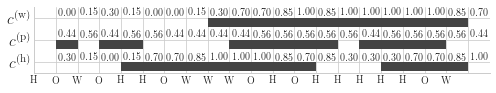

{'w': 2, 'h': 0, 'p': 1}


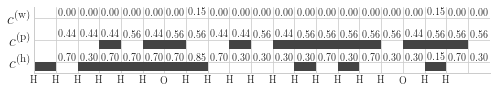

{'w': 2, 'h': 0, 'p': 1}


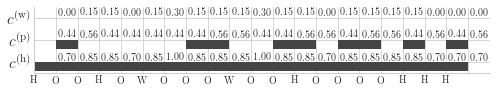

{'w': 2, 'h': 0, 'p': 1}


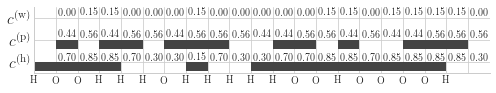

{'w': 2, 'h': 0, 'p': 1}


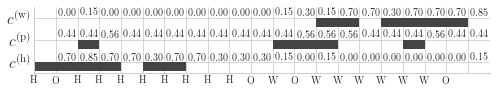

{'w': 2, 'h': 0, 'p': 1}


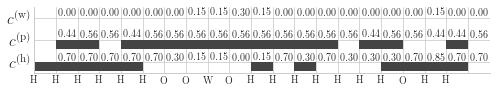

{'w': 2, 'h': 0, 'p': 1}


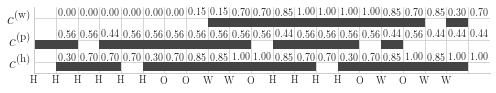

{'w': 2, 'h': 0, 'p': 1}


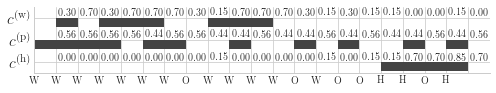

{'w': 2, 'h': 0, 'p': 1}


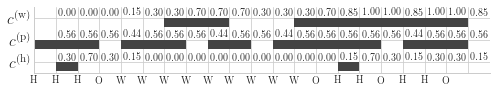

{'w': 2, 'h': 0, 'p': 1}


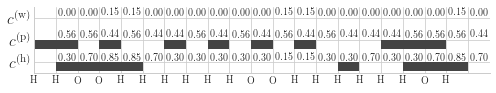

In [133]:
sample={
    'observations': observations,
    'states': states,
}
for i in range(10):
    sample['state_seq']=compute_state_seq(model2.sample(length=20, path=True), observations)
    sample['predictions']=predict_next_states(model2, sample)
    plot_device_usage_timeline(sample, prediction=True, figsize=(7, 1.4), fn="timelines/{:02}.svg".format(i+1))
    #sample

# Predicting future states

{'h': 0, 'p': 1, 'w': 2}


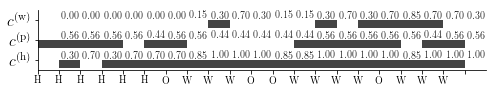

In [51]:
sample={
    'observations': observations,
    'states': states,
}
sample['state_seq']=compute_state_seq(model2.sample(length=20, path=True), observations)
sample['predictions']=predict_next_states(model2, sample)
plot_device_usage_timeline(sample, prediction=True, figsize=(7, 1.4))

In [28]:
# Returns set of all combinations of k-sized boolean arrays
# having an even or odd (even=False) number of True values
def toggle_combinations(k, even=True):
    ret = set()
    
    # n_toggles contains any odd/even number in [0, k]
    for n_toggles in range(0, k+1, 2):
        if not even:
            n_toggles+=1
            if n_toggles > k:
                continue
        
        # arr is a boolean array with n_toggles True
        arr = np.zeros(k, np.bool)
        arr[:n_toggles] = True
        # Add all permutations of arr to ret
        ret.update(permutations(arr))
    
    return ret

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


In [57]:
toggle_combinations(2, even=False)

{(False, True), (True, False)}

In [55]:
# Returns P the array of future toggle probability for observation obs
# P size: up_to x |states|
# P[k-1, s] = P[O_(t+k) = toggle_obs | S_(t+k)=s]
def compute_future_toggle_probability(up_to, model, states, obs):
    P = np.zeros((up_to, len(states)))
    A=model.dense_transition_matrix()
    
    for t in range(1, up_to+1):
        for state in range(len(states)):
            compute_future_toggle_probability_rec(P, t, state, model, states, obs, A)
    
    return P
def compute_future_toggle_probability_rec(P, t, state, model, states, obs, A):
    # P[t-1, s]: probability of toggling in t turns knowing current state s
    P[t-1, state]=0
    if t == 1:
        # P[toggle|current_state] = sum_(s in states)(P[s|current_state] * P[toggle|s])
        for s in range(len(states)):
            p_next_state_knowing_state = A[state, s]
            # Probability of toggling now knowing current state
            p_obs = get_observation_probability(model, s, obs)
            P[t-1, state] += p_next_state_knowing_state * p_obs
    else:
        # P[toggle|current_state] = sum_(s in states)(P[s|current_state] * P[toggle|s])
        for s in range(len(states)):
            p_next_state_knowing_state = A[state, s]
            # Probability of toggling in t-1 turns knowing current state
            p_obs = P[t-2, s]
            P[t-1, state] += p_next_state_knowing_state * p_obs
            
    return P[t-1, s]

compute_future_toggle_probability(4, model, states, 'w')

['H', 'O', 'W']


array([[ 0.        ,  0.14814815,  0.2962963 ],
       [ 0.04938272,  0.14814815,  0.24691358],
       [ 0.08230453,  0.14814815,  0.21399177],
       [ 0.1042524 ,  0.14814815,  0.1920439 ]])

In [ ]:
def compute_future_connection_probability(up_to, model, states, current_state, obs, connected):
    P = compute_future_toggle_probability(up_to, model, states, obs)
    
    ret = []
    for t in range(up_to):
        p = 0
        # Sum each toggle history's probability
        for toggle_history in toggle_combinations(t+1, even=connected):
            tmp = 1
            # Toggle history probability:
            # Product of the proba that I will toggle (or not) at each step
            for k, toggle in enumerate(toggle_history):
                if toggle:
                    # Proba of toggling in k+1 turns knowing that I am currently in current_state
                    tmp *= P[k, states.index(current_state)]
                else:
                    # Proba of not toggling in k+1 turns knowing that I am currently in current_state
                    tmp *= 1 - P[k, states.index(current_state)]

            p += tmp
        ret.append(p)
    return ret

In [75]:
compute_future_connection_probability(10, model, states, 'H', 'w', connected=False)

[0.0,
 0.049382716049382713,
 0.12355840065030735,
 0.20204828144749976,
 0.27289185421718432,
 0.33132175058685248,
 0.37691278279118845,
 0.41124854871209376,
 0.43651921772123287,
 0.45483907000310447]

In [76]:
compute_future_connection_probability(10, model, states, 'H', 'p', connected=False)

[0.44444444444444442,
 0.49382716049382713,
 0.4993141289437586,
 0.49992379210486204,
 0.49999153245609584,
 0.49999905916178849,
 0.49999989546242074,
 0.49999998838471266,
 0.4999999987094122,
 0.49999999985660426]

In [77]:
compute_future_connection_probability(10, model, states, 'H', 'h', connected=False)

[0.29629629629629628,
 0.39689071787837221,
 0.4410197933542952,
 0.46367337066677439,
 0.47656292913160442,
 0.48442172442355236,
 0.48944273647745595,
 0.49275389365941558,
 0.4949846605106184,
 0.49650934198589902]

## Sequential model

In [16]:
at_home_dist=DiscreteDistribution({'none': 0, 'phone': 1/2, 'home computer': 1/2, 'work station': 0})
in_transit_dist=DiscreteDistribution({'none': 2/3, 'phone': 1/3, 'home computer': 0, 'work station': 0})
at_work_dist=DiscreteDistribution({'none': 0, 'phone': 1/2, 'home computer': 0, 'work station': 1/2})

at_home_state=State(at_home_dist, name="At home")
in_transit_state=State(in_transit_dist, name="In transit")
at_work_state=State(at_work_dist, name="At work")

model=HiddenMarkovModel(name="Sequential user")
model.add_states([at_home_state, in_transit_state, at_work_state])
model.add_transition(model.start, at_home_state, 0.8)
model.add_transition(model.start, at_work_state, 0.2)
model.add_transition(at_home_state, at_home_state, 2/3)
model.add_transition(at_home_state, in_transit_state, 1/3)
model.add_transition(in_transit_state, in_transit_state, 1/3)
model.add_transition(in_transit_state, at_home_state, 1/3)
model.add_transition(in_transit_state, at_work_state, 1/3)
model.add_transition(at_work_state, at_work_state, 2/3)
model.add_transition(at_work_state, in_transit_state, 1/3)
model.bake()

In [17]:
res=model.sample(length=20, path=True)
sample=from_pomegranate_sample(res, toggle=False)

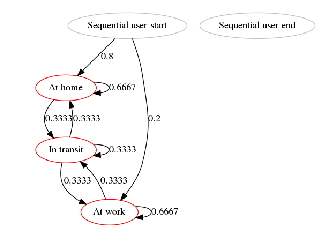

In [4]:
model.plot()

{'work station': 2, 'phone': 1, 'home computer': 0}


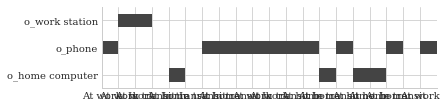

[('At work', 'phone'),
 ('At work', 'work station'),
 ('At work', 'work station'),
 ('In transit', 'none'),
 ('At home', 'home computer'),
 ('In transit', 'none'),
 ('In transit', 'phone'),
 ('At home', 'phone'),
 ('In transit', 'phone'),
 ('At work', 'phone'),
 ('At work', 'phone'),
 ('In transit', 'phone'),
 ('At home', 'phone'),
 ('At home', 'home computer'),
 ('In transit', 'phone'),
 ('At home', 'home computer'),
 ('At home', 'home computer'),
 ('At home', 'phone'),
 ('In transit', 'none'),
 ('At work', 'phone')]

In [18]:
plot_device_usage_timeline(sample, toggle=False)
sample['state_seq']